In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from helper_funcs import *

In [2]:
zipdata = get_zipdata()
zipdata.shape

----pulling ZipCode data from Azure storage----
----Done----


(6987, 24)

In [3]:
#zipdata = zipdata.loc[zipdata.Population!=0]

In [4]:
zipdata.isna().sum()

Population              0
HouseholdsPerZipCode    0
AverageHouseValue       0
IncomePerHousehold      0
MedianAge               0
NumberOfBusinesses      0
over_65_ratio           0
school_rating           0
Hosp_count              0
HPI                     0
Demand_score            0
Supply_score            0
listviews_vs_US         0
med_days_on_mkt         0
nielson_rank            0
UE_rate                 0
Zillow_HVF              0
BEA_percap_income       0
Blacks_ratio            0
Hispanics_ratio         0
Asians_ratio            0
Indians_ratio           0
Others_ratio            0
Male_ratio              0
dtype: int64

Check Some correlations

<AxesSubplot:>

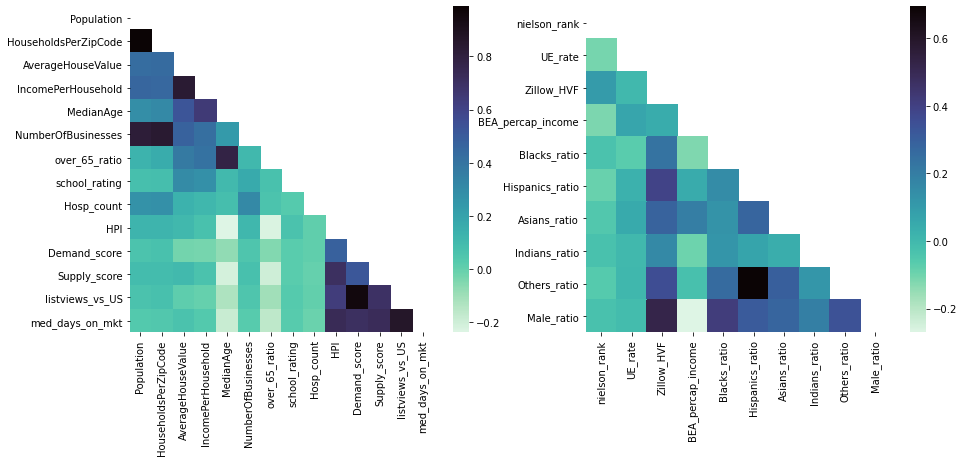

In [5]:
corr1 = zipdata.iloc[:,0:14].corr()
corr2 = zipdata.iloc[:,14:].corr()

mask1 = np.triu(np.ones_like(corr1, dtype=bool)) # Hide upper redundant heatmap
mask2 = np.triu(np.ones_like(corr2, dtype=bool)) # Hide upper redundant heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(corr1, mask=mask1, ax=ax[0], annot=False, cmap='mako_r')
sns.heatmap(corr2, mask=mask2, ax=ax[1], annot=False, cmap='mako_r')

### 🎚️ Scale data before clustering

In [6]:
mms = MinMaxScaler()
# REMOVE AverageHouseValue
to_use = ['Population', 'HouseholdsPerZipCode', 'Blacks_ratio', 'Hispanics_ratio', 
          'Asians_ratio', 'Indians_ratio', 'Others_ratio', 'Male_ratio',                # Population
          'IncomePerHousehold', 'NumberOfBusinesses','UE_rate', 'BEA_percap_income',    # Econ
          'over_65_ratio','MedianAge',                                                  # Age
          'HPI', 'Demand_score','Supply_score', 'listviews_vs_US', 'med_days_on_mkt', 'nielson_rank', # FRED
         ]

data_scaled = pd.DataFrame(mms.fit_transform(zipdata[to_use].values), 
                           columns=zipdata[to_use].columns, 
                           index=zipdata[to_use].index)
# data_scaled = pd.DataFrame(mms.fit_transform(zipdata.drop(columns=['AverageHouseValue','school_rating']).values), 
#                            columns=zipdata.drop(columns=['AverageHouseValue','school_rating']).columns, 
#                            index=zipdata.drop(columns=['AverageHouseValue','school_rating']).index)

### K-means Clustering of ZipCode data to produce desirability Clusters

In [7]:
kmeans = KMeans()
inertias = {}
for n in range(1,15):
    kmeans.set_params(n_clusters=n)
    kmeans.fit(data_scaled[['HPI', 'Demand_score','Supply_score', 'listviews_vs_US', 'med_days_on_mkt', 'nielson_rank']])
    inertias[n] = kmeans.inertia_

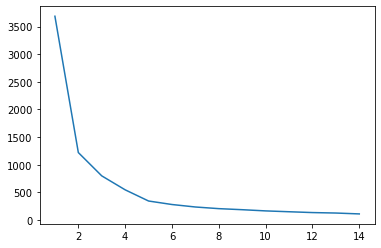

In [8]:
plt.plot(inertias.keys(),inertias.values())

#### Try X Clusters

In [9]:
kmeans.set_params(n_clusters=5)
kmeans.fit(data_scaled[['HPI', 'Demand_score','Supply_score', 'listviews_vs_US', 'med_days_on_mkt', 'nielson_rank']])
zipdata['fred_cluster'] = kmeans.labels_

In [ ]:
zipdata.columns

In [ ]:
print(zipdata.groupby('cluster').agg('count')['Population'])
zipdata.groupby('cluster').agg('mean')[['AverageHouseValue','Population','over_65_ratio',
                                       'IncomePerHousehold','school_rating','Hosp_count',
                                       'HPI','UE_rate','Zillow_HVF','NumberOfBusinesses']].round(2).sort_values(by='AverageHouseValue')

## 🎰 Model with Clusters

In [18]:
RF = get_redfin_csv()
print(RF.shape)

----pulling Redfin data from Azure storage----
----Done----
(74717, 21)


In [19]:
RF.Detached.value_counts()

1    50224
0    24493
Name: Detached, dtype: int64

#### Merge cluster into House data

In [20]:
print(f'shape before merge: {RF.shape}')
RF = RF.merge(zipdata, how = 'left', left_on = 'zip', right_index=True)
#RF.cluster = RF.cluster.astype('object')
print(f'shape after merge: {RF.shape}')

shape before merge: (74717, 21)
shape after merge: (74717, 46)


In [ ]:
sns.boxplot(x=RF.cluster, y=np.log10(RF.PRICE))

## Try Linear Model and CatBoost🐱
* Label Encode **Prop_Type & zip**

In [103]:
# target_feats = ['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip']
# target_feats = ['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip','cluster']
# target_feats = ['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip','cluster','school_rating']
target_feats = ['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip',
               'pop_cluster', 'econ_cluster', 'age_cluster', 'fred_cluster','school_rating','Zillow_HVF']
# target_feats = ['Prop_Type', 'BEDS', 'BATHS', 'SF', 'Lot_Size', 'YearBuilt', 'zip',
#         'Population', 'HouseholdsPerZipCode', 'MedianAge', 'NumberOfBusinesses', 
#         'over_65_ratio', 'school_rating', 'Hosp_count', 'HPI', 'Demand_score', 
#         'Supply_score', 'listviews_vs_US', 'med_days_on_mkt', 'nielson_rank', 
#         'UE_rate', 'Zillow_HVF', 'BEA_percap_income', 'Blacks_ratio', 
#         'Hispanics_ratio', 'Asians_ratio', 'Indians_ratio', 'Others_ratio', 
#         'Male_ratio']

lm = LinearRegression()
cat = CatBoostRegressor(verbose=False)

LM_train_R2 = []
LM_test_R2 = []

CAT_train_R2 = []
CAT_test_R2 = []

for i in range(5):
    X_train_dum, X_test_dum, X_train_le, X_test_le, y_train, y_test = get_train_test(RF,target_feats)
    lm.fit(X_train_dum, y_train)
    LM_train_R2.append(lm.score(X_train_dum, y_train))
    LM_test_R2.append(lm.score(X_test_dum, y_test))
   
    cat.fit(X_train_le, y_train)
    CAT_train_R2.append(cat.score(X_train_le, y_train))
    CAT_test_R2.append(cat.score(X_test_le, y_test))
    print(i+1)

print(f'Linear Model train R2: {np.average(LM_train_R2)}')
print(f'Linear Model test R2: {np.average(LM_test_R2)}')
print(f'CatBoost train R2: {np.average(CAT_train_R2)}')
print(f'CatBoost Model test R2: {np.average(CAT_test_R2)}')

4
5
Linear Model train R2: 0.7564106237398096
Linear Model test R2: 0.6940527804434616
CatBoost train R2: 0.8662031744466588
CatBoost Model test R2: 0.8394565184933434


## 🏕️ Try RandomForest and parameter tuning... manually

In [ ]:
randoforest = RandomForestRegressor(n_jobs=-1)
randoforest.get_params()

In [ ]:
target_feats = ['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip']

FST_train_R2 = []
FST_test_R2 = []

for i in range(5):
    X_train, X_test, y_train, y_test = get_train_test_LE(RF,target_feats)
    randoforest.fit(X_train, y_train)
    FST_train_R2.append(randoforest.score(X_train, y_train))
    FST_test_R2.append(randoforest.score(X_test, y_test))
    print(i+1)

print(f'RandForest train R2: {np.average(FST_train_R2)}')
print(f'RandForest test R2: {np.average(FST_test_R2)}')

In [ ]:
randoforest.set_params(max_depth=5,n_estimators=50)

target_feats = ['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip']

FST_train_R2 = []
FST_test_R2 = []

for i in range(5):
    X_train, X_test, y_train, y_test = get_train_test_LE(RF,target_feats)
    randoforest.fit(X_train, y_train)
    FST_train_R2.append(randoforest.score(X_train, y_train))
    FST_test_R2.append(randoforest.score(X_test, y_test))
    print(i+1)

print(f'RandForest train R2: {np.average(FST_train_R2)}')
print(f'RandForest test R2: {np.average(FST_test_R2)}')

In [ ]:
randoforest.set_params(max_depth=8,n_estimators=50)

target_feats = ['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip']

FST_train_R2 = []
FST_test_R2 = []

for i in range(5):
    X_train, X_test, y_train, y_test = get_train_test_LE(RF,target_feats)
    randoforest.fit(X_train, y_train)
    FST_train_R2.append(randoforest.score(X_train, y_train))
    FST_test_R2.append(randoforest.score(X_test, y_test))
    print(i+1)

print(f'RandForest train R2: {np.average(FST_train_R2)}')
print(f'RandForest test R2: {np.average(FST_test_R2)}')

In [ ]:
randoforest.set_params(max_depth=25, min_samples_leaf=10, n_estimators=50)

target_feats = ['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip']

FST_train_R2 = []
FST_test_R2 = []

for i in range(5):
    X_train, X_test, y_train, y_test = get_train_test_LE(RF,target_feats)
    randoforest.fit(X_train, y_train)
    FST_train_R2.append(randoforest.score(X_train, y_train))
    FST_test_R2.append(randoforest.score(X_test, y_test))
    print(i+1)

print(f'RandForest train R2: {np.average(FST_train_R2)}')
print(f'RandForest test R2: {np.average(FST_test_R2)}')

## Miniscule improvements with Cluster information

🦏 Try **Full** Model by directly adding ZipCode Level information & feature select with Lasso

In [21]:
# Use all columns except 
# PRICE, Sale_Type, Sold_Date, ADDRESS, CITY, State, px_perSF, HOA_perMonth, 
# Status, LATITUDE, LONGITUDE, LOCATION, Days_on_Mkt, AverageHouseValue
unwanted = ['PRICE','Sale_Type', 'Sold_Date', 'ADDRESS', 'CITY', 'State', 'LOCATION',
            'Days_on_Mkt', 'px_perSF', 'HOA_perMonth', 'STATUS', 'LATITUDE', 'LONGITUDE']
RF.drop(columns=unwanted).columns

Index(['Prop_Type', 'BEDS', 'BATHS', 'SF', 'Lot_Size', 'YearBuilt', 'zip',
       'Detached', 'Population', 'HouseholdsPerZipCode', 'AverageHouseValue',
       'IncomePerHousehold', 'MedianAge', 'NumberOfBusinesses',
       'over_65_ratio', 'school_rating', 'Hosp_count', 'HPI', 'Demand_score',
       'Supply_score', 'listviews_vs_US', 'med_days_on_mkt', 'nielson_rank',
       'UE_rate', 'Zillow_HVF', 'BEA_percap_income', 'Blacks_ratio',
       'Hispanics_ratio', 'Asians_ratio', 'Indians_ratio', 'Others_ratio',
       'Male_ratio', 'fred_cluster'],
      dtype='object')

In [22]:
# target_feats = ['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip']
# target_feats = ['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip','cluster']
target_feats = ['Prop_Type', 'BEDS', 'BATHS', 'SF', 'Lot_Size', 'YearBuilt', 'zip',
        'Population', 'MedianAge', 'NumberOfBusinesses', 'over_65_ratio', 'school_rating', 
        'Hosp_count', 'HPI', 'Demand_score', 'Supply_score', 'listviews_vs_US', 
        'med_days_on_mkt', 'nielson_rank', 'UE_rate', 'Zillow_HVF', 'BEA_percap_income', 
        'Blacks_ratio', 'Hispanics_ratio', 'Asians_ratio', 'Indians_ratio', 'Others_ratio', 
        'Male_ratio']

lm = LinearRegression()
cat = CatBoostRegressor(verbose=False)

LM_train_R2 = []
LM_test_R2 = []

CAT_train_R2 = []
CAT_test_R2 = []

for i in range(5):
    X_train_dum, X_test_dum, X_train_le, X_test_le, y_train, y_test = get_train_test(RF,target_feats)
    lm.fit(X_train_dum, y_train)
    LM_train_R2.append(lm.score(X_train_dum, y_train))
    LM_test_R2.append(lm.score(X_test_dum, y_test))
   
    cat.fit(X_train_le, y_train)
    CAT_train_R2.append(cat.score(X_train_le, y_train))
    CAT_test_R2.append(cat.score(X_test_le, y_test))
    print(i+1)

print(f'Linear Model train R2: {np.average(LM_train_R2)}')
print(f'Linear Model test R2: {np.average(LM_test_R2)}')
print(f'CatBoost train R2: {np.average(CAT_train_R2)}')
print(f'CatBoost Model test R2: {np.average(CAT_test_R2)}')

1
2
3
4
5
Linear Model train R2: 0.7546250207623304
Linear Model test R2: 0.733724640556409
CatBoost train R2: 0.8865694302837636
CatBoost Model test R2: 0.854619232624786


In [23]:
lasso = Lasso()
lasso.set_params(normalize=True, max_iter=10000, random_state=44)
lasso.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 10000,
 'normalize': True,
 'positive': False,
 'precompute': False,
 'random_state': 44,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [24]:
#try different alphas
alphas = np.linspace(0.00001,0.0005,20)
coefs_lasso = []
R2_train = []
R2_test = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_dum, y_train)
    coefs_lasso.append(lasso.coef_)
    R2_train.append(lasso.score(X_train_dum, y_train))
    R2_test.append(lasso.score(X_test_dum, y_test))

In [25]:
coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = X_train_dum.columns)
R2_lasso = pd.DataFrame({'train': R2_train,'test':R2_test}, index = alphas)
coefs_lasso.head(2)

,BEDS,BATHS,SF,Lot_Size,YearBuilt,Population,MedianAge,NumberOfBusinesses,over_65_ratio,school_rating,...,zip_34981,zip_34982,zip_34983,zip_34984,zip_34986,zip_34987,zip_34990,zip_34994,zip_34996,zip_34997
0.000010,0.007649,0.007818,0.000144,1.600246e-10,0.001082,-0.000003,0.003652,0.000104,0.068540,0.011687,...,0.0,-0.0,0.0,-0.0,-0.013951,-0.0,-0.045774,-0.010296,0.0,-0.064317
0.000036,0.004652,0.008562,0.000150,0.000000e+00,0.000626,-0.000003,0.002533,0.000086,0.065343,0.015646,...,0.0,-0.0,0.0,-0.0,-0.000000,-0.0,-0.000000,-0.000000,0.0,-0.000000


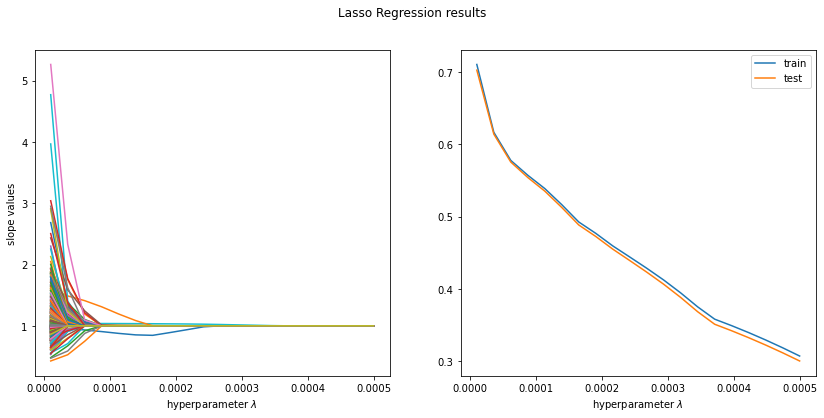

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('Lasso Regression results')

for feat in coefs_lasso.columns:
    ax1.plot(coefs_lasso.index, 10**coefs_lasso[feat]) 
ax1.set_xlabel(r'hyperparameter $\lambda$')
ax1.set_ylabel(r'slope values')
#ax1.legend(loc=1)
for each in R2_lasso.columns:
    ax2.plot(R2_lasso.index, R2_lasso[each], label=each)
ax2.set_xlabel(r'hyperparameter $\lambda$')
ax2.legend(loc=1)

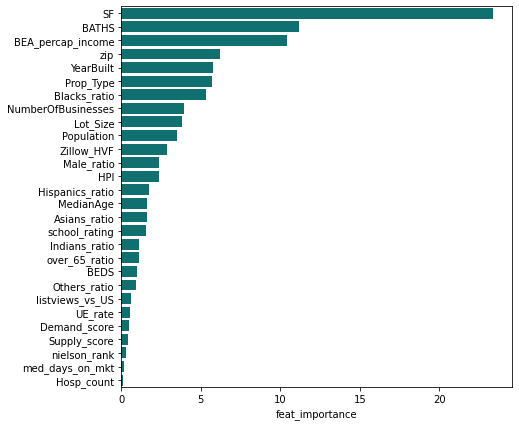

In [27]:
feat_importances = pd.DataFrame(cat.get_feature_importance(), index=X_train_le.columns, columns=['feat_importance'])
feat_importances = feat_importances.sort_values(by='feat_importance', ascending=False)

f, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x='feat_importance', y=feat_importances.index, data=feat_importances, color="teal");

In [ ]:
Cat_scores = []

for num in range(3,len(feat_importances.index)):
    print(num)
    X_train_new = X_train_le[[*feat_importances.index[:num]]]
    X_test_new = X_test_le[[*feat_importances.index[:num]]]
    cat.fit(X_train_new, y_train)
    Cat_scores.append(cat.score(X_test_new, y_test))

In [ ]:
plt.plot(Cat_scores)